# Part 1: Training a Neural Network

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from utils import * 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
cwd = os.getcwd()

train_path = os.path.join(cwd,'Data','train_val')
test_path  = os.path.join(cwd,'Data','test')

In [10]:
input_train = xr.open_dataset(os.path.join(train_path,'forcing_train.nc'))
input_test = xr.open_dataset(os.path.join(test_path,'forcing_test.nc'))

In [13]:
output_train = xr.open_dataset(os.path.join(train_path,'member_165_train.nc'))
output_test = xr.open_dataset(os.path.join(test_path,'member_165_test.nc'))

In [27]:
X_train_df = pd.DataFrame({"delta_T": input_train.delta_T.data},index=input_train.delta_T.coords['time'].data)

In [20]:
y_df_stack = output_train.velsurf_mag.stack(dim=["y", "x"])


In [21]:
y_df_stack

<xarray.DataArray 'velsurf_mag' (time: 1049, dim: 145161)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
  * time     (time) float64 -1.249e+05 -1.248e+05 ... -2e+04 -1.99e+04
  * dim      (dim) object MultiIndex
  * y        (dim) float64 -3.04e+06 -3.04e+06 -3.04e+06 ... 3.04e+06 3.04e+06
  * x        (dim) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Attributes:
    long_name:    magnitude of horizontal velocity of ice at ice surface
    units:        m year-1
    pism_intent:  diagnostic

In [24]:
y_train_df = pd.DataFrame(y_df_stack.to_pandas())

In [117]:
y_train_df = y_train_df.fillna(0)

In [118]:
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy()

In [119]:
print(X_train.shape,y_train.shape)

(1049, 1) (1049, 145161)


In [120]:
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    y_pred = y_pred[(y_true != 0) & (y_true != 0.0)]
    y_true = y_true[(y_true != 0) & (y_true != 0.0)]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)

    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true),axis= -1))

In [167]:
n_neuron       = 64
activation     = 'relu'
num_epochs     = 50
learning_rate  = 0.001
minibatch_size = 32
model_num      = 1

In [168]:
model = Sequential()

model.add(Dense(n_neuron,  activation=activation,input_shape=(X_train.shape[1],))) #  the 1st hidden layer 
model.add(Dense(n_neuron,  activation=activation)) # the 2nd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 3rd hidden layer
model.add(Dense(n_neuron,  activation=activation)) # the 4th hidden layer
model.add(Dense(y_train.shape[1],  activation='linear')) # the output layer


model.compile(loss=custom_rmse,optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))

In [169]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 64)                128       
                                                                 
 dense_21 (Dense)            (None, 64)                4160      
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dense_23 (Dense)            (None, 64)                4160      
                                                                 
 dense_24 (Dense)            (None, 145161)            9435465   
                                                                 
Total params: 9,448,073
Trainable params: 9,448,073
Non-trainable params: 0
_________________________________________________________________


In [170]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


history = model.fit(X_train, y_train, 
                    batch_size      = minibatch_size,
                    epochs          = num_epochs,
                    validation_split= 0.2, 
                    verbose         = 1,
                    callbacks       = [early_stop])



Epoch 1/50
27/27 [==============================] - 1s 35ms/step - loss: 123.2446 - val_loss: 83.1812
Epoch 2/50
27/27 [==============================] - 0s 16ms/step - loss: 120.5881 - val_loss: 71.6370
Epoch 3/50
27/27 [==============================] - 0s 15ms/step - loss: 106.4329 - val_loss: 77.7671
Epoch 4/50
27/27 [==============================] - 0s 16ms/step - loss: 95.8576 - val_loss: 73.6592
Epoch 5/50
27/27 [==============================] - 0s 15ms/step - loss: 92.1738 - val_loss: 69.5449
Epoch 6/50
27/27 [==============================] - 0s 15ms/step - loss: 90.8058 - val_loss: 70.4461
Epoch 7/50
27/27 [==============================] - 0s 15ms/step - loss: 90.2332 - val_loss: 69.2376
Epoch 8/50
27/27 [==============================] - 0s 15ms/step - loss: 89.5095 - val_loss: 68.2129
Epoch 9/50
27/27 [==============================] - 0s 16ms/step - loss: 88.8248 - val_loss: 69.6526
Epoch 10/50
27/27 [==============================] - 0s 16ms/step - loss: 87.5347 - val_

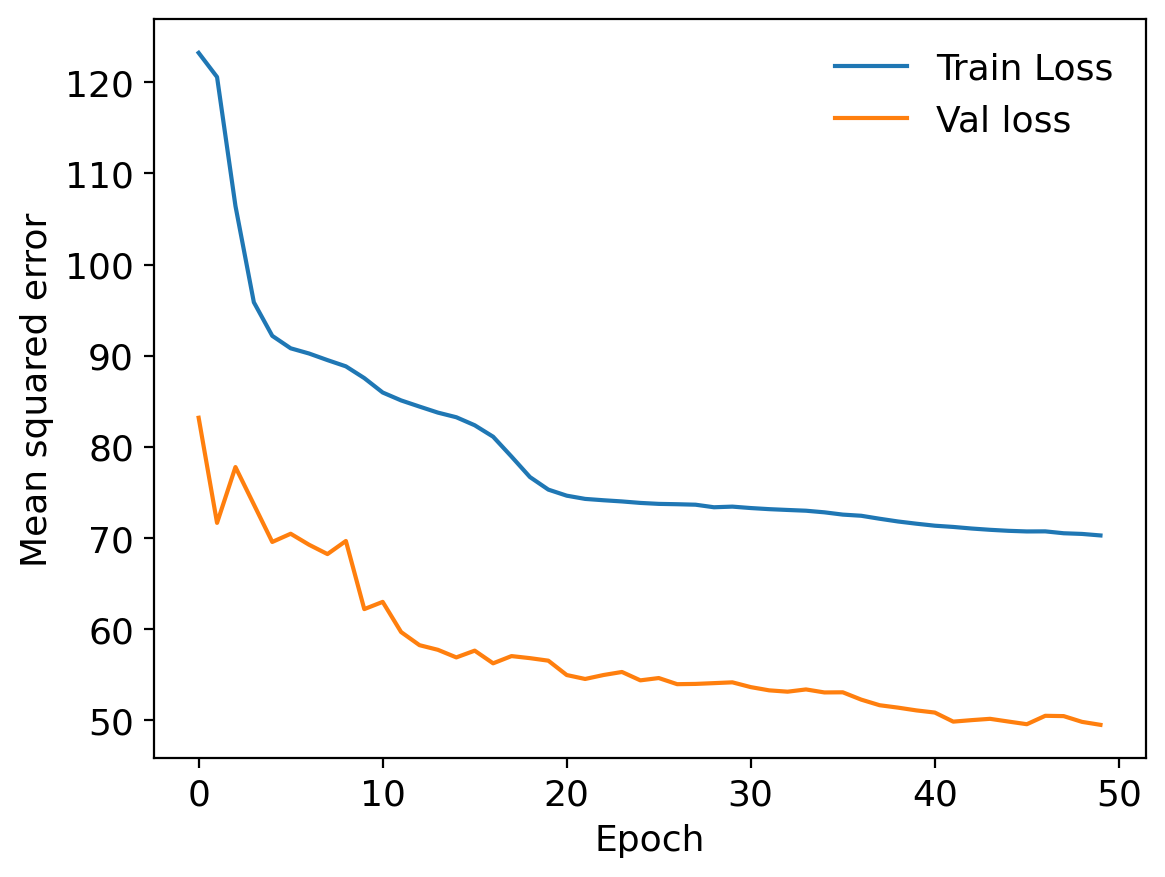

In [171]:
plot_history(history)

In [172]:
model_path = os.path.join(cwd,'saved_model')
make_dir(model_path)

In [173]:
model.save(os.path.join(model_path,'NN_model_1_member.h5'))

## Testing

In [174]:
model = load_model(os.path.join(model_path,'NN_model_1_member.h5'),custom_objects={'custom_rmse':custom_rmse})

In [175]:
X_test_df = pd.DataFrame({"delta_T": input_test.delta_T.data},index=input_test.delta_T.coords['time'].data)

In [176]:
y_test_df = pd.DataFrame(output_test.velsurf_mag.stack(dim=["y", "x"]).to_pandas()).fillna(0)

In [177]:
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

In [178]:
y_test_pre = model.predict(X_test)


7/7 [==============================] - 0s 2ms/step


In [179]:
y_test_pre_rs = y_test_pre.reshape(y_test_df.index.values.shape[0],y_test_df.columns.levels[1].shape[0],y_test_df.columns.levels[0].shape[0])

y_test_pre_xr = xr.Dataset(coords={'time': y_test_df.index.values, 
                               'x': y_test_df.columns.levels[1].values, 
                               'y': y_test_df.columns.levels[0].values},
                       data_vars=dict(velsurf_mag=(['time', 'y', 'x'], y_test_pre_rs)))

In [180]:
y_test_pre_xr

<xarray.Dataset>
Dimensions:      (time: 200, y: 381, x: 381)
Coordinates:
  * time         (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... 0.0 50.0
  * x            (x) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
  * y            (y) float64 -3.04e+06 -3.024e+06 ... 3.024e+06 3.04e+06
Data variables:
    velsurf_mag  (time, y, x) float32 -1.363 -1.095 -1.314 ... -1.668 -1.482

In [181]:
y_true =  y_test_df.unstack().to_xarray()

In [182]:
y_true

<xarray.DataArray (y: 381, x: 381, time: 200)>
array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
...
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]], dtype=float32)
Coordinates:
  * y        (y) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * x        (x) float64 -3.04e+06 -3.024e+06 -3.008e+06 ... 3.024e+06 3.04e+06
  * time     (time) float64 -1.98e+04 -1.97e+04 -1.96e+04 ... -100.0 0.0 50.0

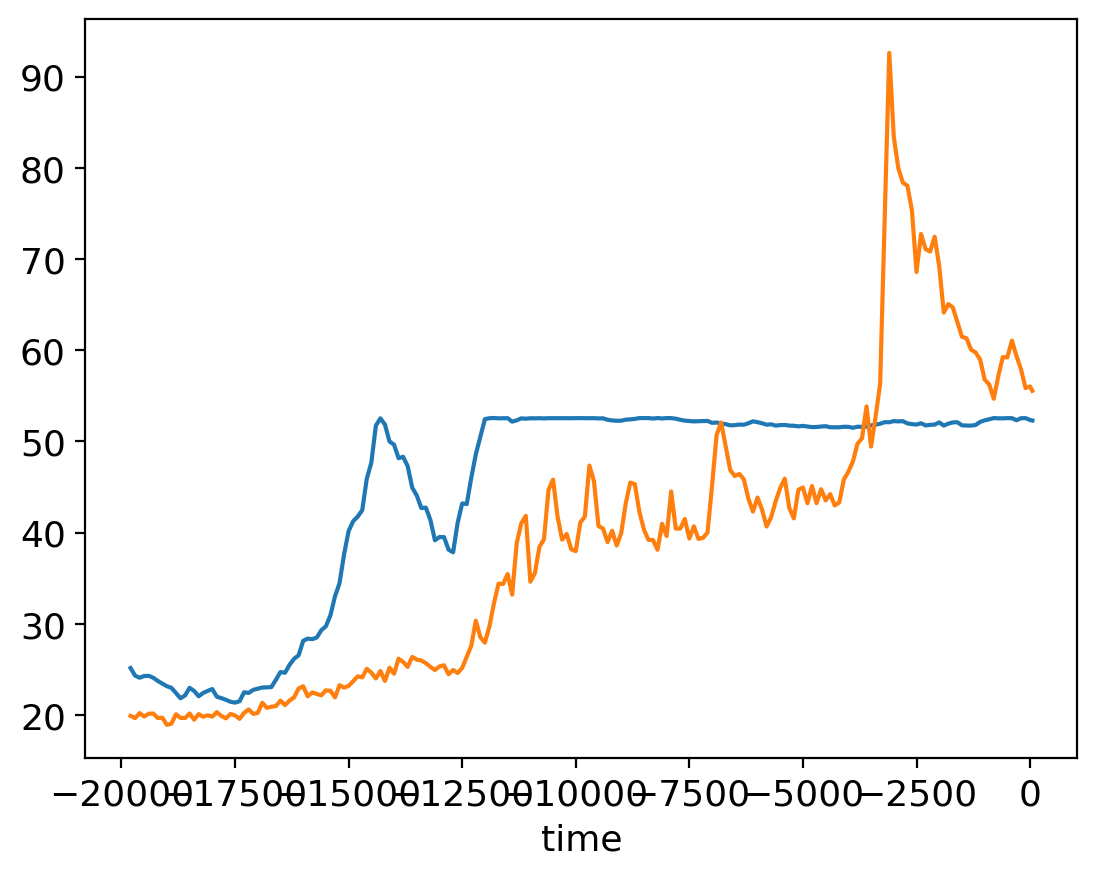

In [183]:
y_test_pre_xr.velsurf_mag.mean(dim=['x','y']).plot()
y_true.mean(dim=['x','y']).plot()

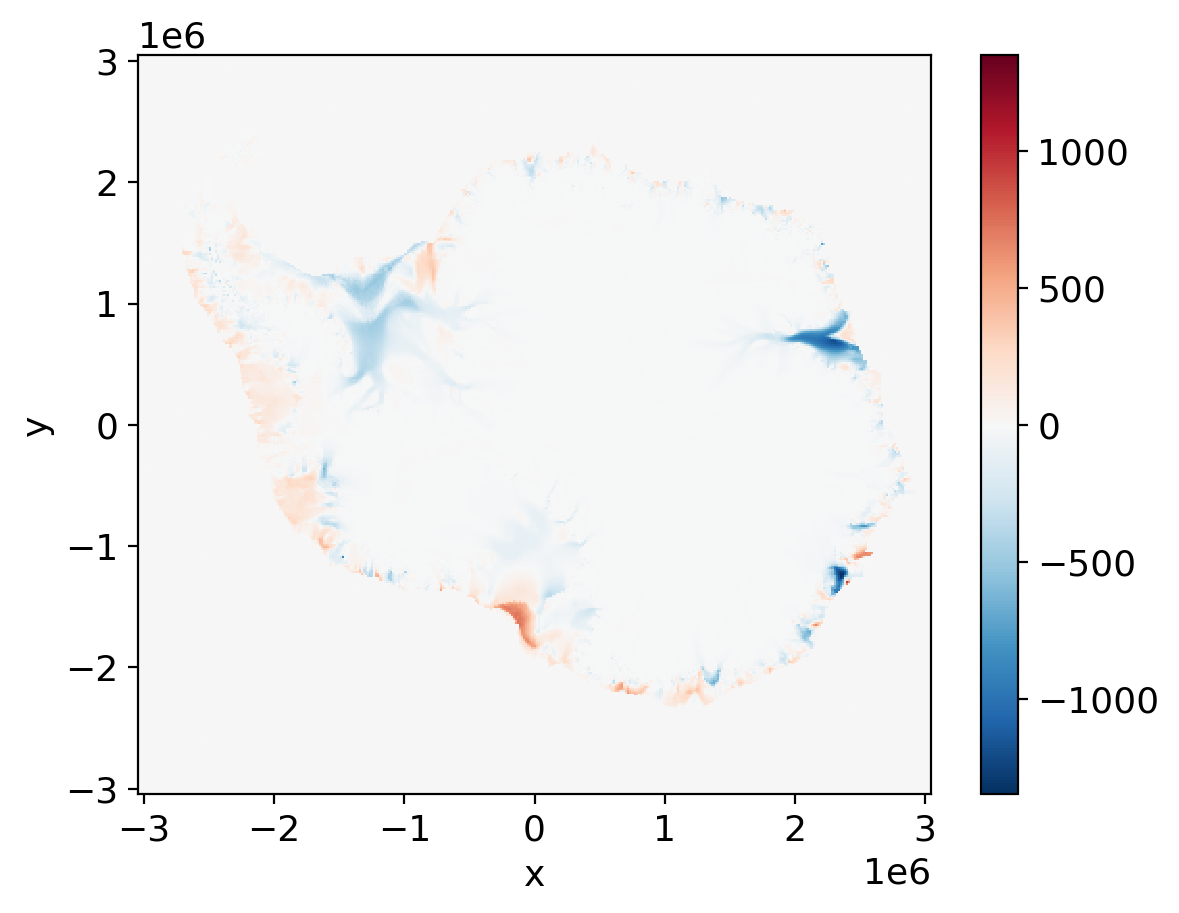

In [184]:
(y_true-y_test_pre_xr.velsurf_mag).mean(dim='time').plot()

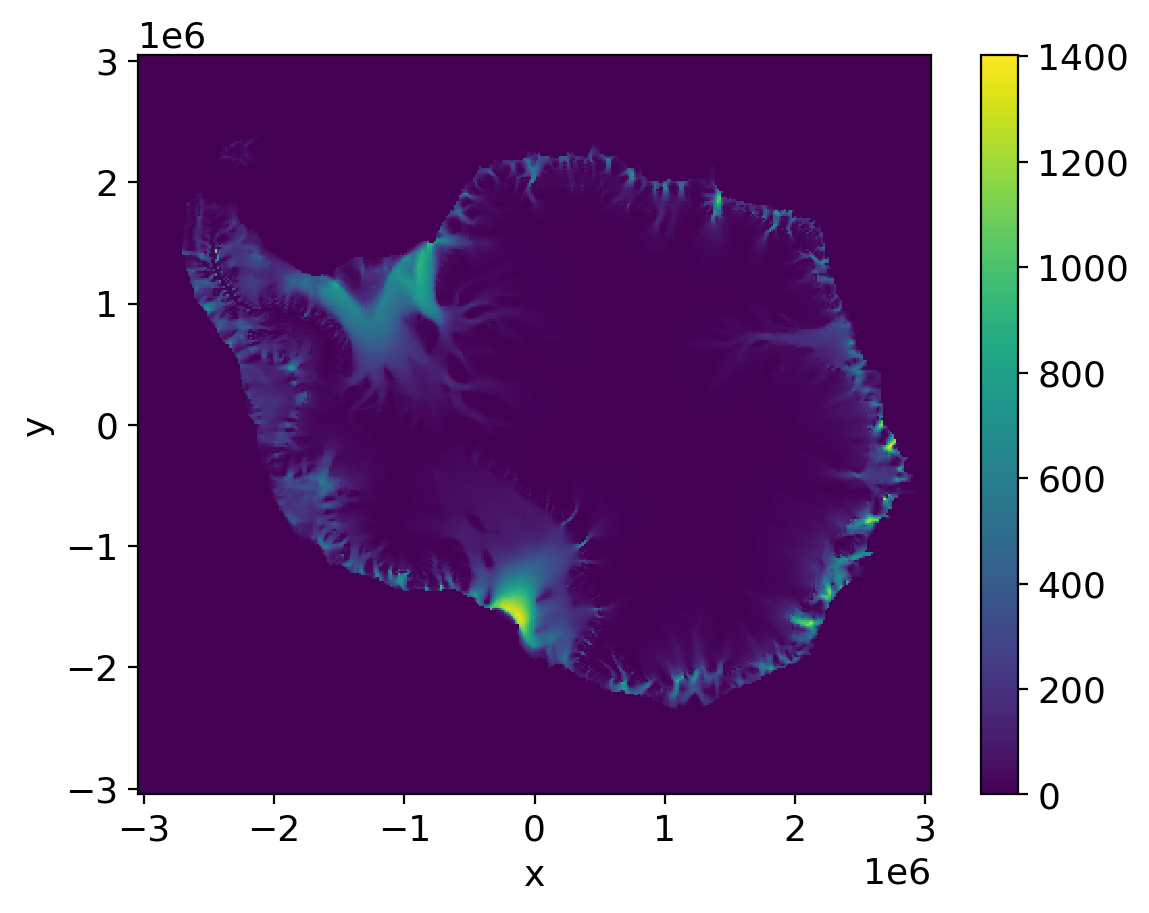

In [185]:
y_true.mean(dim='time').plot()

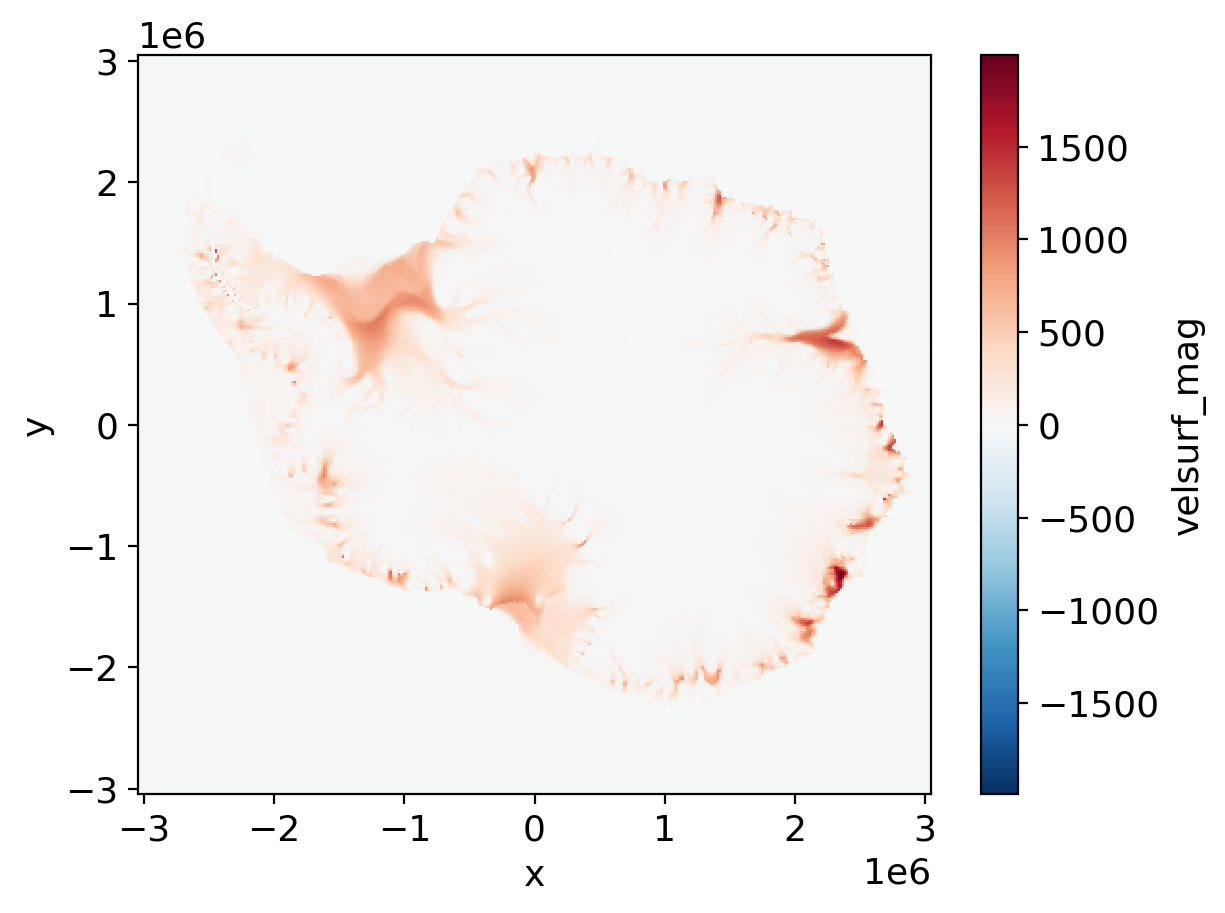

In [186]:
y_test_pre_xr.velsurf_mag.mean(dim='time').plot()